In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.special import gammaln,gamma
from scipy.special.orthogonal import hermitenorm

from math import log, floor, exp

### Deconstruction and reconstruction using continous wavelet transform (CWT)


*** CWT  analysis technique should always be based on the perfect reconstruction procedure***
- Perfect reconstruction procedure: processing and analysing a selected subset from the coefficients that exactly reproduce the original function 


-  If perfect reconstruction is not achieved - analysis could show some artefacts or signal that do not exist in the dataset


- Recall wavelet transform contain information about both the signal and the wavelet (and not only the filtered signal)


- **For orthogonal wavelet bases (DWT)**
    - reconstruction is done through deconvolution or inverse filter (as in Fourier transform)
    - summing of the wavelet coefficients
    
    
- **For non-orthogonal wavelets (CWT - i.e Halo, Morlet, Morse)**
    - reconstruction cannot be done through "straightforward" inverse filter due to the redundancy in time and scale
    
    - however redundancy implies that reconstruction can be done using a completely different wavelet function (reconstruct $f(x)$ from its wavelet coefficients (WT) using another wavelet function ${\psi}$) 
    
    - ***analysing wavelet can be different from the synthesising wavelet (provided both wavelets satisfy the admissibility conditions)***
    
    - note: same wavelet can also be used for reconstruction

#### Recall wavelet properties and parseval's theorem 

#### General reconstruction/inversion formula
- when using same wavelet ($\psi$) for decomposition and reconstruction

$f(t) = C_{\psi}^{-1} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} a^{-2} \big(W_{\psi}f\big)(a,b) \ \psi_{a,b}(t) \ db da$

- when using a wavelet ($\psi$) for the forward transform and a different wavelet ($\psi'$) for the inverse transform  

$f(t) = C_{\psi,\psi'}^{-1} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} a^{-2} \big(W_{\psi}f\big)(a,b) \ \psi'_{a,b}(t) \ db da$

- where ${C_{\psi}}$ is the reconstruction factor and depends on the wavelet type 


### Finding ${C_{\psi}}$ using the Dirac $\delta$ function
#### Inverse formula using the $\delta$ function as the reconstruction wavelt ${\psi'}$ is just the sum of the real part of the wavelet transform over all scales - from Torrence & Compo (1998)

${x_n = \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} \sum_{j=0}^J  \frac{R \{W_n(s_j) \}}{s_j^{1/2} }  }$

- ${\psi_0(0)}$ removes the energy scaling (note time-domain wavelet)
- ${s_j^{1/2}}$ converts the wavelet transform to an energy density
- $C_\delta$ is the reconstruction factor 

#### Reconstruction factor ${C_\delta}$ for an new wavelet function can be found empirically  using the Dirac ${\delta}$ function as input signal


- Considering a $\delta$ function as input signal (${x_n}$):
    - ${x_n = \delta_{n0}}$
    - $\hat{x}_k = N^{-1}$ (constant for all k)
    - $W_{\delta}(s) = \frac{1}{N} \sum_{k=0}^{N-1} \hat{\psi}*(s\omega_k)$
    
    
- Using properties of the $\delta$ function, ${C_\delta}$ can be found as:

 ${C_{\delta}= \frac{\delta j \delta t^{1/2}}{\psi_0(0)} \sum_{j=0}^J  \frac{R \{W_\delta(s_j) \}}{s_j^{1/2} }  }$

    
    
- ***${C_\delta}$ is independent of scale and is constant for each wavelet function***
- ${C_\delta}$ for different wavelet bases given in Table 2, Torrence & Compo, 1998


#### For perfect reconstruction, following properties required (Wang, 2020):

- Values of the scale parameter ($s_j$) should form a geometric sequence (e.g logarithmic scale discretisation). Other discretisation schemes (e.g linear) are less efficient numerically and require extra scaling to achieve perfect reconstruction)


- Second property is for anisotropic wavelets (e.g fan wavelets) - check paper for more info

#### Trying reconstruction of a signal using the Mexican Hat 

- Properties of wavelet such as ${\psi_0(\eta), \psi_0(\omega), C_\delta}$ given in Torrence & Compo, 1998

#### defining Mexican hat and properties  - Torrence and Compo (1998)


In [2]:
#mexican hat
class DOG():
    from scipy.special import gamma
    """Implements the derivative of a Guassian wavelet class.
    Note that the input parameter f is the angular frequency and that
    for m=2 the DOG becomes the Mexican hat wavelet, which is then
    default.
    """
    def __init__(self, m=2):
        self._set_m(m)
        self.name = 'DOG'

    def psi_ft(self, f):
        """Fourier transform of the DOG wavelet."""
        return (- 1j ** self.m / np.sqrt(gamma(self.m + 0.5)) * f ** self.m *
                np.exp(- 0.5 * f ** 2))

    def psi(self, t):
        """DOG wavelet as described in Torrence and Compo (1998).
        The derivative of a Gaussian of order `n` can be determined using
        the probabilistic Hermite polynomials. They are explicitly
        written as:
            Hn(x) = 2 ** (-n / s) * n! * sum ((-1) ** m) *
                    (2 ** 0.5 * x) ** (n - 2 * m) / (m! * (n - 2*m)!)
        or in the recursive form:
            Hn(x) = x * Hn(x) - nHn-1(x)
        Source: http://www.ask.com/wiki/Hermite_polynomials
        """
        p = hermitenorm(self.m)
        return ((-1) ** (self.m + 1) * np.polyval(p, t) *
                np.exp(-t ** 2 / 2) / np.sqrt(gamma(self.m + 0.5)))

    def flambda(self):
        """Fourier wavelength as of Torrence and Compo (1998)."""
        return (2 * np.pi / np.sqrt(self.m + 0.5))

    def coi(self):
        """e-Folding Time as of Torrence and Compo (1998)."""
        return 1 / np.sqrt(2)

    def sup(self):
        """Wavelet support defined by the e-Folding time."""
        return 1 / self.coi

    def _set_m(self, m):
        # Sets the m derivative of a Gaussian, the degrees of freedom and the
        # empirically derived factors for the wavelet bases C_{\delta},
        # \gamma, \delta j_0 (Torrence and Compo, 1998, Table 2).
        self.m = m               # m-derivative
        self.dofmin = 1          # Minimum degrees of freedom
        if self.m == 2:
            self.cdelta = 3.541  # Reconstruction factor
            self.gamma = 1.43    # Decorrelation factor for time averaging
            self.deltaj0 = 1.40  # Factor for scale averaging
        elif self.m == 6:
            self.cdelta = 1.966
            self.gamma = 1.37
            self.deltaj0 = 0.97
        else:
            self.cdelta = -1
            self.gamma = -1
            self.deltaj0 = -1

### Case 1: Computing inverse wavelet transform without the reconstruction factor, ${C_{\psi}}$ (only summing as in the Fourier transforms) 
- wavelets are non-orthogonal - simple sum of the wavelet transform should not give back orignal function

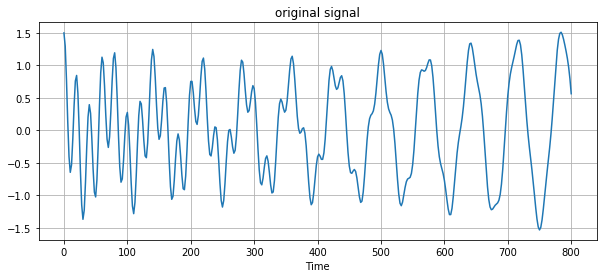

In [3]:
#creating signal
#option 1
#creating data for testing
#dt = 2
#t = np.arange(1,200+1)*dt
#amp = 0.5
#f = 0.02
#t_period = 1/f
#x0 =amp*np.cos(2*np.pi*f*t)*np.exp(1.8e-3*t);

#option 2
dt = 2
t = np.arange(0,400+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.014
t1_period = 1/f1
x1 =amp1*np.cos(2*np.pi*f1*t)*np.exp(1.4e-3*t);

amp2 = 1
f2 = 0.05
t2_period = 1/f2
x2 = amp2*np.cos(2*np.pi*f2*t)*np.exp(-0.3e-2*t);

x0 = x1 + x2

fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0)
plt.title("original signal")
plt.xlabel("Time")
plt.grid()
plt.show()


#### Picking up scales (as from Torrence and Compo, 1998)
- scales are chosen as fractional power of two 
- Recall that logarithmic scale discretisation is better

${s_j = s_02^{j\delta j}}$ where  ${j = 0,1,...J}$

${ J = \delta j^{-1} log_2(N \delta t/s_0)}$

- ${s_0}$ is the smallest resolvable scale - (depends on $2\delta t$)
- $J$ determines the largest scale
- ${\delta j}$ depends on the width of the wavelet function in spectral space (max value for each wavelet type given in Torrence and Compo)

In [4]:
#defining scales (here using Mexican hat)
wavelet=DOG()

dj = 0.5                      # largest value for Mexican hat (1.4)
n0 = len(x0)                     # Original signal length 
N = 2 ** (int(np.log2(n0)) + 1)  # Next higher power of 2 (for more efficient computation)
s0 = 2 * dt                      # Smallest resolvable scale:
J = int(np.log2(N * dt / s0) / dj)     # Number of scales

sj = s0 * 2 ** (np.arange(0, J+1) * dj) # The scales

#compute Fourier equivalent wavelength 
t_scale = (wavelet.flambda() * sj)
f_scale = 1/t_scale


#### Computing wavelet transforms and plotting real part of the wavelet transforms 
- Normalise wavelet function to have unit energy) - Torrence equation (6)
- wavelet transform is weighted only by the amplitude of the
Fourier coefficients ${\hat{x}_k}$ and not by the wavelet function

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


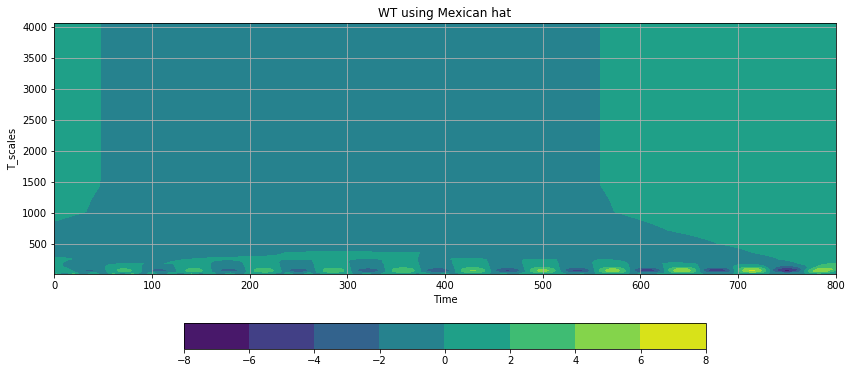

In [7]:
signal_ft = np.fft.fft(x0, N)             # Signal fourier transform

# Fourier angular frequencies to get omega
ftfreqs = 2 * np.pi * np.fft.fftfreq(N, dt)  #gives eqn (5) in Torrence

#wavelet transform will have size sj*N
WT = np.zeros((len(sj), N), 'complex')

for n, s in enumerate(sj):
    #compute wavelet at specific scale 
    psi_ft_bar = ((s * ftfreqs[1] * N) ** .5 * 
                    np.conjugate(wavelet.psi_ft(s * ftfreqs)))
    
    WT[n, :] = np.fft.ifft(signal_ft * psi_ft_bar, N)
    
# Checks for NaN in transform results and removes them from the scales,
# frequencies and wavelet transform.
sel = np.logical_not(np.isnan(WT).all(axis=1))
sj = sj[sel]
f_scale = f_scale[sel]
WT = WT[sel, :n0]

fig, ax = plt.subplots(1,figsize=(14,6))

fig1 = plt.contourf(t,t_scale,(WT))
fig.colorbar(fig1,orientation="horizontal",fraction=0.08)
plt.title("WT using Mexican hat")
plt.ylabel("T_scales")
plt.xlabel("Time")
plt.grid()
plt.show()


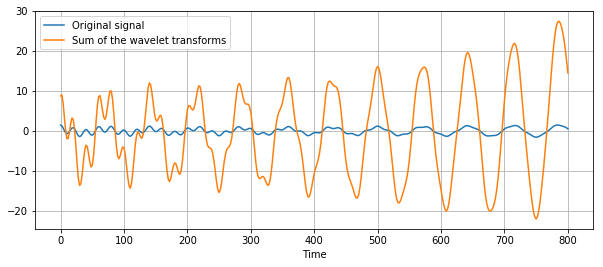

In [8]:
fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0,label="Original signal")
plt.plot(t,np.sum(np.real(WT),axis=0),label="Sum of the wavelet transforms")
plt.legend()
plt.xlabel("Time")
plt.grid()
plt.show()

***Remarks***
- set of $\hat{\psi}(s \omega)$ has been normalised to have unit energy prior to computing WT
- however superposition of WT gives back a signal that is much bigger than the original one (due to redundancy in terms of time and s when applying an orthogonal CWT )


### Case 2: Reconstruction using $\delta$ function  for the backward transform (forward wavelet transform using Mexican hat as before)

- Equation define above or in equation (11) of Torrence & Compo (1998)
- $C_{\delta}$ for Mexican hat (Table 2 in Torrence & Compo, 1998)


In [9]:
#tile over sj for easier multiplication
a, b = WT.shape
c = sj.size
if a == c:
    sj_tile = (np.ones([b, 1]) * sj).transpose()
elif b == c:
    sj_tile = np.ones([a, 1]) * sj
    
iWT = (dj * np.sqrt(dt)) / (wavelet.cdelta * wavelet.psi(0)) * (np.real(WT) / sj_tile**0.5).sum(axis=0)



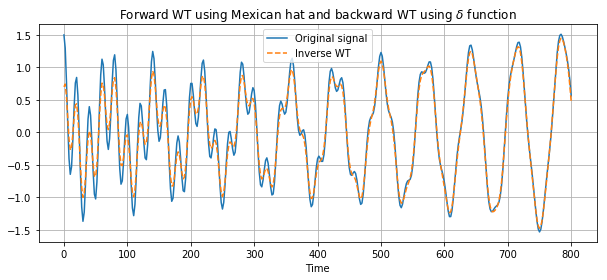

In [10]:
fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0,label="Original signal")
plt.plot(t,iWT,label="Inverse WT",linestyle="--")
plt.title("Forward WT using Mexican hat and backward WT using $\delta$ function")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.show()


***Remarks***
- Inverse formula and reconstruction factor, recovers original signal

### Case 2: Reconstruction using $\delta$ function  for the backward transform (forward wavelet transform using Morlet wavelet)

#### defining Morlet and properties  - Torrence and Compo (1998)


In [11]:
class Morlet:
    """
    Implements the Morlet wavelet class.
    Note that the input parameters f and f0 are angular frequencies.
    f0 should be more than 0.8 for this function to be correct, its
    default value is f0=6.
    #TODO: Implenment arbitarty order
    """

    def __init__(self, f0=6.0):
        self._set_f0(f0)
        self.name = 'Morlet'

    def psi_ft(self, f):
        """Fourier transform of the approximate Morlet wavelet."""
        return (np.pi ** -.25) * np.exp(-0.5 * (f - self.f0) ** 2.)

    def psi(self, t):
        """Morlet wavelet as described in Torrence and Compo (1998)."""
        return (np.pi ** -.25) * np.exp(1j * self.f0 * t - t ** 2. / 2.)

    def flambda(self):
        """Fourier wavelength as of Torrence and Compo (1998)."""
        return (4 * np.pi) / (self.f0 + np.sqrt(2 + self.f0 ** 2))

    def coi(self):
        """e-Folding Time as of Torrence and Compo (1998)."""
        return 1. / np.sqrt(2.)

    def sup(self):
        """Wavelet support defined by the e-Folding time."""
        return 1. / self.coi

    def _set_f0(self, f0):
        # Sets the Morlet wave number, the degrees ofFalse freedom and the
        # empirically derived factors for the wavelet bases C_{\delta}, \gamma,
        # \delta j_0 (Torrence and Compo, 1998, Table 2)
        self.f0 = f0             # Wave number
        self.dofmin = 2          # Minimum degrees of freedom
        if self.f0 == 6.:
            self.cdelta = 0.776  # Reconstruction factor
            self.gamma = 2.32    # Decorrelation factor for time averaging
            self.deltaj0 = 0.60  # Factor for scale averaging
        else:
            self.cdelta = -1
            self.gamma = -1
            self.deltaj0 = -1

In [14]:
#defining scales (here using Mexican hat)
wavelet=Morlet()

dj = 0.4                     # largest value for Morlet=0.5,omega_0=6 (0.6)
n0 = len(x0)                     # Original signal length 
N = 2 ** (int(np.log2(n0)) + 1)  # Next higher power of 2 (for more efficient computation)
s0 = 2 * dt                      # Smallest resolvable scale:
J = int(np.log2(N * dt / s0) / dj)     # Number of scales

sj = s0 * 2 ** (np.arange(0, J+1) * dj) # The scales

#compute Fourier equivalent wavelength 
t_scale = (wavelet.flambda() * sj)
f_scale = 1/t_scale


/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


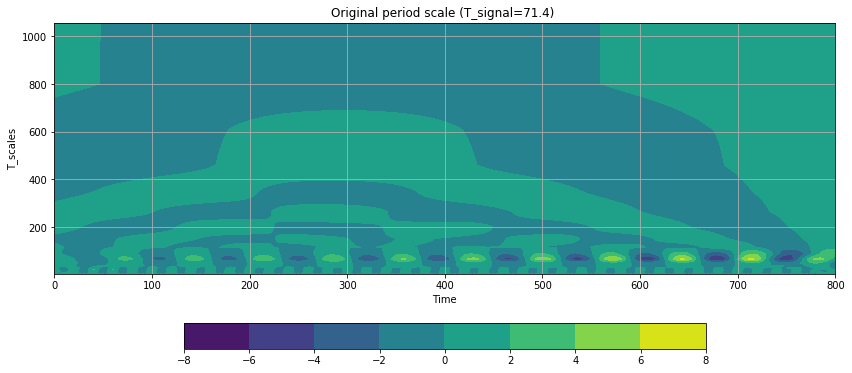

In [17]:
# computing wavelet transform
signal_ft = np.fft.fft(x0, N)             # Signal fourier transform

# Fourier angular frequencies to get omega
ftfreqs = 2 * np.pi * np.fft.fftfreq(N, dt)  

#wavelet transform will have size sj*N
WT = np.zeros((len(sj), N), 'complex')

for n, s in enumerate(sj):
    #compute wavelet at specific scale 
    psi_ft_bar = ((s * ftfreqs[1] * N) ** .5 * 
                    np.conjugate(wavelet.psi_ft(s * ftfreqs)))
    
    WT[n, :] = np.fft.ifft(signal_ft * psi_ft_bar, N)
    
# Checks for NaN in transform results and removes them from the scales,
# frequencies and wavelet transform.
sel = np.logical_not(np.isnan(WT).all(axis=1))
sj = sj[sel]
f_scale = f_scale[sel]
WT = WT[sel, :n0]

fig, ax = plt.subplots(1,figsize=(14,6))

fig1 = plt.contourf(t,t_scale,(WT))
fig.colorbar(fig1,orientation="horizontal",fraction=0.08)
plt.title("Original period scale (T_signal={:.1f}) ".format(t1_period))
plt.ylabel("T_scales")
plt.xlabel("Time")
plt.grid()
plt.show()


#### computing inverse wavelet transforms ($C_{\delta}$ is taken accordingly for Morlet)

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


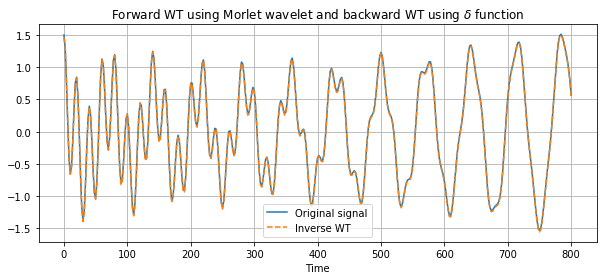

In [18]:
#tile over sj for easier multiplication
a, b = WT.shape
c = sj.size
if a == c:
    sj_tile = (np.ones([b, 1]) * sj).transpose()
elif b == c:
    sj_tile = np.ones([a, 1]) * sj
    
iWT = (dj * np.sqrt(dt)) / (wavelet.cdelta * wavelet.psi(0)) * (np.real(WT) / sj_tile**0.5).sum(axis=0)

fig, ax = plt.subplots(1,figsize=(10,4))
plt.plot(t,x0,label="Original signal")
plt.plot(t,iWT,label="Inverse WT",linestyle="--")
plt.title("Forward WT using Morlet wavelet and backward WT using $\delta$ function")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.show()

### Case 3: Reconstruction using same basis functions (Morlet) for both forward and backward transforms 
- data in is made cyclic (not to worry about edge points)
- $C_{\psi}$ not known for Morlet in inverse wavelet transform/reconstruction

In [19]:
#creating signal
#option 1
#creating data for testing
dt = 2
t = np.arange(1,500+1)*dt
amp = 0.5
f = 0.012
t_period = 1/f
x0 =amp*np.sin(2*np.pi*f*t)#*np.exp(1.8e-3*t);

In [23]:
#defining scales (here using Mexican hat)
wavelet=Morlet()

dj = 0.5                    # largest value for Morlet,omega_0=6 (0.6)
n0 = len(x0)                     # Original signal length 
N = 2 ** (int(np.log2(n0)) + 1)  # Next higher power of 2 (for more efficient computation)
s0 = 2 * dt                      # Smallest resolvable scale:
J = int(np.log2(N * dt / s0) / dj)     # Number of scales

sj = s0 * 2 ** (np.arange(0, J+1) * dj) # The scales

#compute Fourier equivalent wavelength 
t_scale = (wavelet.flambda() * sj)
f_scale = 1/t_scale

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


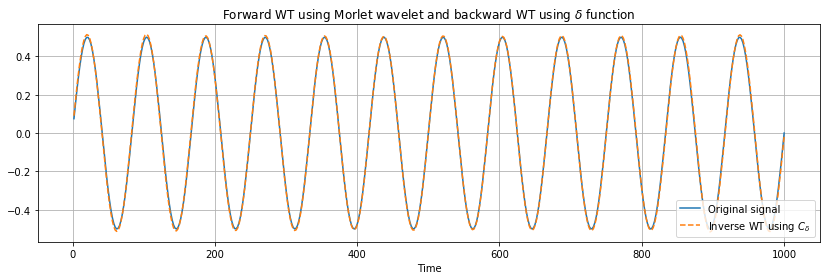

In [24]:
# computing wavelet transform
signal_ft = np.fft.fft(x0, N)             # Signal fourier transform

# Fourier angular frequencies to get omega
ftfreqs = 2 * np.pi * np.fft.fftfreq(N, dt)  

#wavelet transform will have size sj*N
WT = np.zeros((len(sj), N), 'complex')

for n, s in enumerate(sj):
    #compute wavelet at specific scale 
    psi_ft_bar = ((s * ftfreqs[1] * N) ** .5 * 
                    np.conjugate(wavelet.psi_ft(s * ftfreqs)))
    
    WT[n, :] = np.fft.ifft(signal_ft * psi_ft_bar, N)
    
# Checks for NaN in transform results and removes them from the scales,
# frequencies and wavelet transform.
sel = np.logical_not(np.isnan(WT).all(axis=1))
sj = sj[sel]
f_scale = f_scale[sel]
WT = WT[sel, :n0]


#tile over sj for easier multiplication
a, b = WT.shape
c = sj.size
if a == c:
    sj_tile = (np.ones([b, 1]) * sj).transpose()
elif b == c:
    sj_tile = np.ones([a, 1]) * sj

#inverse formula using delta function
iWT = (dj * np.sqrt(dt)) / (wavelet.cdelta * wavelet.psi(0)) * (np.real(WT) / sj_tile**0.5).sum(axis=0)
fig, ax = plt.subplots(1,figsize=(14,4))
plt.plot(t,x0,label="Original signal")
plt.plot(t,iWT,label="Inverse WT using $C_{\delta}$",linestyle="--")
plt.title("Forward WT using Morlet wavelet and backward WT using $\delta$ function")
plt.xlabel("Time")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### Trying reconstruction with same wavelet (Morlet for both forward and backward)

- getting equations from the book (Two dimensional wavelets and their relative)

$f(t) = C_{\psi}^{-1}\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} a^{-2} \big(W_{\psi}f\big)(a,b) \ \psi_{a,b}(t) \ db da$

- ${\big(W_{\psi}f\big)(a,b)}$ are the wavelet transforms using Morlet
- where the translated and dilated time-dimain Morlet wavelet, ${\psi_{a,b}}(t) = a^{-1/2}\psi\big(\frac{x-b}{a} \big)$
     - $a$ is the scaling and $b$ the time shift
     
- thus ***operation is a convolution in the time domain***

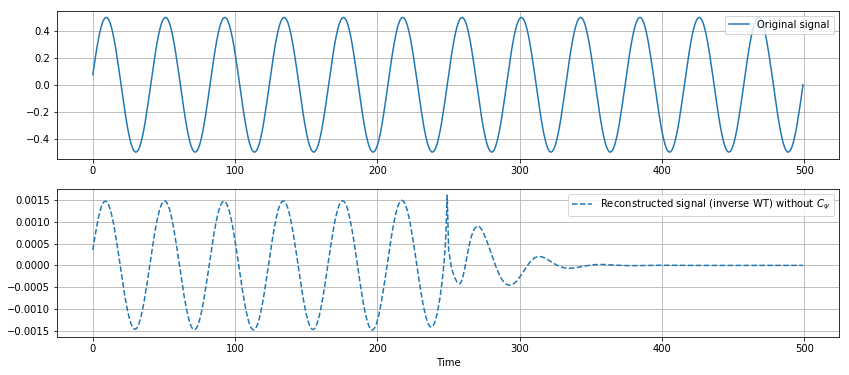

In [25]:
#computing convolution bit
#psi = wavelet.psi(t)#[0:int(len(t)/2)])
psi_sj = (sj_tile**-0.5)*wavelet.psi(t/sj_tile)

WT_conv = np.zeros(np.shape(WT),'complex')
#WT_conv = np.zeros((len(sj),501),'complex')

for ii in np.arange(len(sj)):
    WT_conv[ii,:] = sj[ii]**-2 * np.convolve(WT[ii,:],psi_sj[ii,:],'same')
    
#summing over scales (take reak part given that original signal is real)
iWT = np.real(WT_conv).sum(axis=0)

fig, ax = plt.subplots(2,1,figsize=(14,6))
ax[0].plot(x0,label="Original signal")
ax[0].legend(loc="upper right")
ax[0].grid()

ax[1].plot(iWT,linestyle="--",label="Reconstructed signal (inverse WT) without ${C_\psi}$")
ax[1].legend(loc="upper right")
ax[1].grid()
ax[1].set_xlabel("Time")
plt.show()

#### Calculating $C_{\psi}$ using ${f(t)}$ and $\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} a^{-2} \big(W_{\psi}f\big)(a,b) \ \psi_{a,b}(t) \ db da$


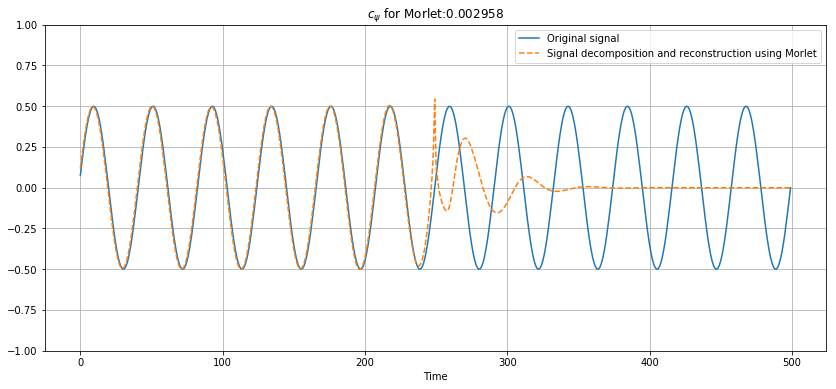

In [26]:
cpsi_morl = np.max(iWT[50:150])/np.max(x0)

#incorporating reconstruction factor 
fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(x0,label="Original signal")
plt.plot(iWT/cpsi_morl,linestyle="--",label="Signal decomposition and reconstruction using Morlet")
plt.title("$c_\psi$ for Morlet:{:3f}".format(cpsi_morl))
plt.ylim(-1,1)
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()

***Remarks***
- Original signal is made cyclic (starts at 0 and finish at 0) - zero padding  might be needed to properly recover signal that are not cyclic 
- Make time wavelet smaller or zero pad input signal to recover whole time series (edge effects are observed above)

### Case 4: Reconstruction using same basis functions (Morlet) for both forward and backward transforms 
- check if $C_{\psi}$ (morlet) computed previously is computed correctly
- data in is made cyclic (not to worry about edge points)


In [27]:
#option 2
dt = 2
t = np.arange(0,500+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.005
t1_period = 1/f1
x1 =amp1*np.sin(2*np.pi*f1*t)*np.exp(1.2e-3*t);

amp2 = 1
f2 = 0.025
t2_period = 1/f2
x2 = amp2*np.sin(2*np.pi*f2*t)*np.exp(-0.15e-2*t);

x0 = x1+x2

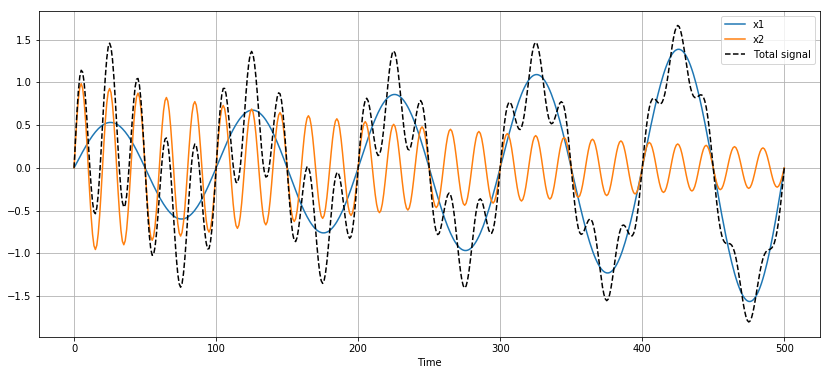

In [28]:
fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(x1,label="x1")
plt.plot(x2,label="x2")
plt.plot(x0,color="k",linestyle="--",label="Total signal")
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()

In [30]:
#defining scales (here using Mexican hat)
wavelet=Morlet()

dj = 0.5                    # largest value for Morlet=0.5,omega_0=6 (0.6)
n0 = len(x0)                     # Original signal length 
N = 2 ** (int(np.log2(n0)) + 1)  # Next higher power of 2 (for more efficient computation)
s0 = 2 * dt                      # Smallest resolvable scale:
J = int(np.log2(N * dt / s0) / dj)     # Number of scales

sj = s0 * 2 ** (np.arange(0, J+1) * dj) # The scales

#compute Fourier equivalent wavelength 
t_scale = (wavelet.flambda() * sj)
f_scale = 1/t_scale

In [31]:
# computing wavelet transform
signal_ft = np.fft.fft(x0, N)             # Signal fourier transform

# Fourier angular frequencies to get omega
ftfreqs = 2 * np.pi * np.fft.fftfreq(N, dt)  

#wavelet transform will have size sj*N
WT = np.zeros((len(sj), N), 'complex')

for n, s in enumerate(sj):
    #compute wavelet at specific scale 
    psi_ft_bar = ((s * ftfreqs[1] * N) ** .5 * 
                    np.conjugate(wavelet.psi_ft(s * ftfreqs)))
    
    WT[n, :] = np.fft.ifft(signal_ft * psi_ft_bar, N)
    
# Checks for NaN in transform results and removes them from the scales,
# frequencies and wavelet transform.
sel = np.logical_not(np.isnan(WT).all(axis=1))
sj = sj[sel]
f_scale = f_scale[sel]
WT = WT[sel, :n0]

/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


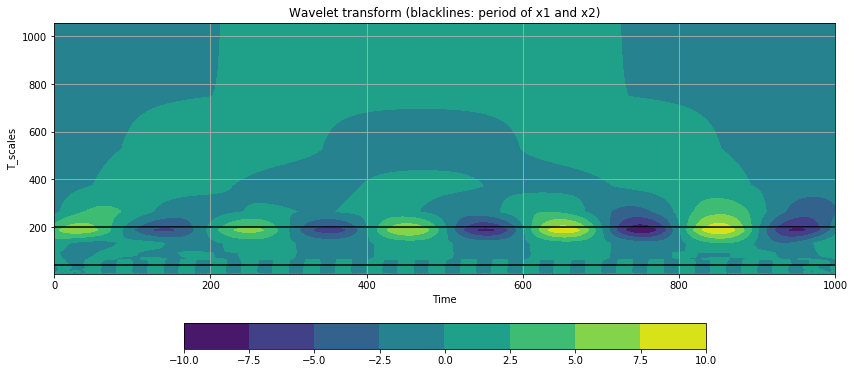

In [32]:
fig, ax = plt.subplots(1,figsize=(14,6))

fig1 = plt.contourf(t,t_scale,(WT))
fig.colorbar(fig1,orientation="horizontal",fraction=0.08)
plt.axhline(y=t1_period,color="k")
plt.axhline(y=t2_period,color="k")

plt.title("Wavelet transform (blacklines: period of x1 and x2)".format(t_period))
plt.ylabel("T_scales")
plt.xlabel("Time")
plt.grid()
plt.show()


In [33]:
### computing inverse WT 
#tile over sj for easier multiplication
a, b = WT.shape
c = sj.size
if a == c:
    sj_tile = (np.ones([b, 1]) * sj).transpose()
elif b == c:
    sj_tile = np.ones([a, 1]) * sj


#computing convolution bit
#psi = wavelet.psi(t)#[0:int(len(t)/2)])
psi_sj = (sj_tile**-0.5)*wavelet.psi(t/sj_tile)

WT_conv = np.zeros(np.shape(WT),'complex')
for ii in np.arange(len(sj)):
    WT_conv[ii,:] = sj[ii]**-2 * np.convolve(WT[ii,:],psi_sj[ii,:],'same')
    
#summing over scales (take reak part given that original signal is real)
iWT = (cpsi_morl**-1)*np.real(WT_conv).sum(axis=0)

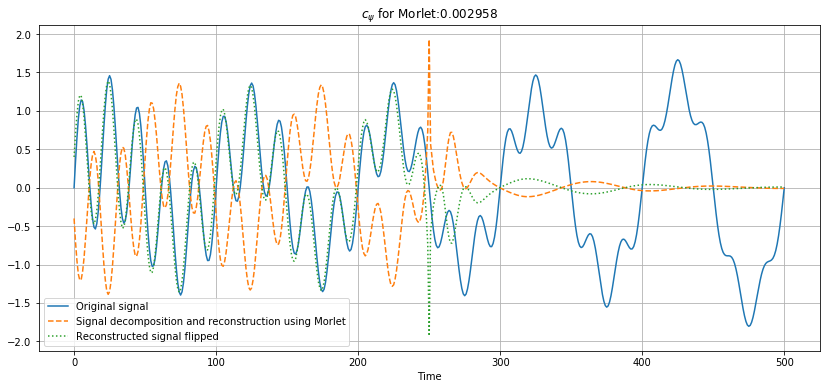

In [34]:
#incorporating reconstruction factor 
fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(x0,label="Original signal")
plt.plot(iWT,linestyle="--",label="Signal decomposition and reconstruction using Morlet")
plt.plot(-1*iWT,linestyle=":",label="Reconstructed signal flipped")

plt.title("$c_\psi$ for Morlet:{:3f}".format(cpsi_morl))
plt.xlabel("Time")
plt.grid()
plt.legend()
plt.show()

***Remarks***
- **reconstructed signal is out of phase with original signal (check sign converision somewhere???)**
- although magnitude and frequency nicely recovered 
- edge effects from convolution still present 


### Checking how $C_\psi$ is computed in Torrence and Compo 

#### Reconstruction factor ${C_\delta}$ for an new wavelet function can be found empirically  using the Dirac ${\delta}$ function as input signal


- Considering a $\delta$ function as input signal (${x_n}$):
    - ${x_n = \delta_{n0}}$
    - $\hat{x}_k = N^{-1}$ (constant for all k)
    - $W_{\delta}(s) = \frac{1}{N} \sum_{k=0}^{N-1} \hat{\psi}*(s\omega_k)$
    
    
- Using properties of the $\delta$ function, ${C_\delta}$ can be found as:

 ${C_{\delta}= \frac{\delta j \delta t^{1/2}}{\psi_0(0)} \sum_{j=0}^J  \frac{R \{W_\delta(s_j) \}}{s_j^{1/2} }  }$

    
    
- ***${C_\delta}$ is independent of scale and is constant for each wavelet function***
- ${C_\delta}$ for different wavelet bases given in Table 2, Torrence & Compo, 1998 (checking for values in table)


#### Defining signal which will be reconstructed


In [35]:
#creating signal
#option 1
#creating data for testing
#dt = 2
#t = np.arange(1,500+1)*dt
#amp = 0.5
#f = 0.012
#t_period = 1/f
#x0 =amp*np.sin(2*np.pi*f*t)#*np.exp(1.8e-3*t);
#plt.plot(t,x0)
#plt.show()


#option 2
dt = 2
t = np.arange(0,500+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.005
t1_period = 1/f1
x1 =amp1*np.sin(2*np.pi*f1*t)*np.exp(1.2e-3*t);

amp2 = 1
f2 = 0.025
t2_period = 1/f2
x2 = amp2*np.sin(2*np.pi*f2*t)*np.exp(-0.15e-2*t);

x0 = x1+x2

#### Compute $C_\delta$ as from Torrence and Compo

In [105]:
#defining scales (here using Mexican hat)
#wavelet=Morlet()
#dj = 0.6 # largest value for Morlet=0.5,omega_0=6 (0.6)

wavelet=DOG()
dj = 0.5 #

n0 = len(x0)                     # Original signal length 
N = 2 ** (int(np.log2(n0)) + 1)  # Next higher power of 2 (for more efficient computation)
s0 = 2 * dt                      # Smallest resolvable scale:
J = int(np.log2(N * dt / s0) / dj)     # Number of scales

sj = s0 * 2 ** (np.arange(0, J+1) * dj) # The scales

# Fourier angular frequencies to get omega
ftfreqs =  np.fft.fftfreq(N, dt) *2 * np.pi 

#compute Fourier equivalent wavelength 
t_scale = (wavelet.flambda() * sj)
f_scale = 1/t_scale

In [106]:
psif_sj = np.zeros((len(sj), N), 'complex')

for ii, s in enumerate(sj):
#compute wavelet at specific scale 
    #scaling ensures psif is unity (eqn 7 in Torrence)
    psif = np.sqrt(2*np.pi*s/dt) * np.conjugate(wavelet.psi_ft(s * ftfreqs))
    psif_sj[ii, :] = psif
    

In [107]:
WT_sum_freq = (1/N)*psif_sj[:,:].sum(axis=1) #for each sj sums over all omega
WT_delta_sum = (np.real(WT_sum_freq)/(sj**0.5)).sum(axis=0)
own_cdelta = (dj*(dt**0.5)) * WT_delta_sum * (np.real(wavelet.psi(0))**-1)
own_cdelta

0.84648987299873646

In [111]:
j = np.arange(len(sj))
np.sum(np.real(WT_sum_freq)/(2**(0.5*j/J))) * (np.log(2)/J)  

0.13996003695935291

*** $C_\delta$ does not correspond to numbers in paper (Tabel 2)!!!***
- cannot find error (operations replicate eqn (13) in Torrence and Compo)
- equation might be wrong??


#### how does $c_\delta$ computed in Torrence and own $C_\delta$ differ?


/Users/jemimarama/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


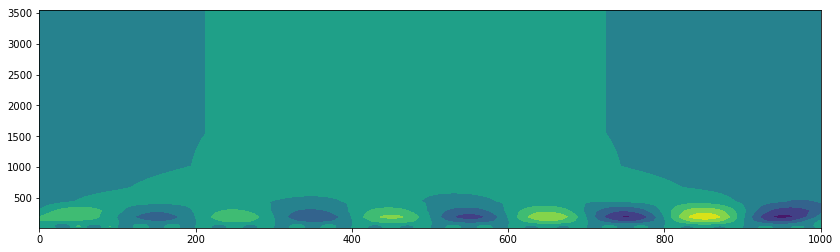

In [39]:
# computing wavelet transform
signal_ft = np.fft.fft(x0, N)             # Signal fourier transform

#wavelet transform will have size sj*N
WT = np.zeros((len(sj), N), 'complex')

for n, s in enumerate(sj):
    #compute wavelet at specific scale 
    psi_ft_bar = ((s * ftfreqs[1] * N) ** .5 * 
                    np.conjugate(wavelet.psi_ft(s * ftfreqs)))
    
    WT[n, :] = np.fft.ifft(signal_ft * psi_ft_bar, N)
    
# Checks for NaN in transform results and removes them from the scales,
# frequencies and wavelet transform.
sel = np.logical_not(np.isnan(WT).all(axis=1))
sj = sj[sel]
f_scale = f_scale[sel]
t_scale = 1/f_scale
WT = WT[sel, :n0]

fig, ax = plt.subplots(1,figsize=(14,4))
plt.contourf(t,t_scale,(WT))
plt.show()

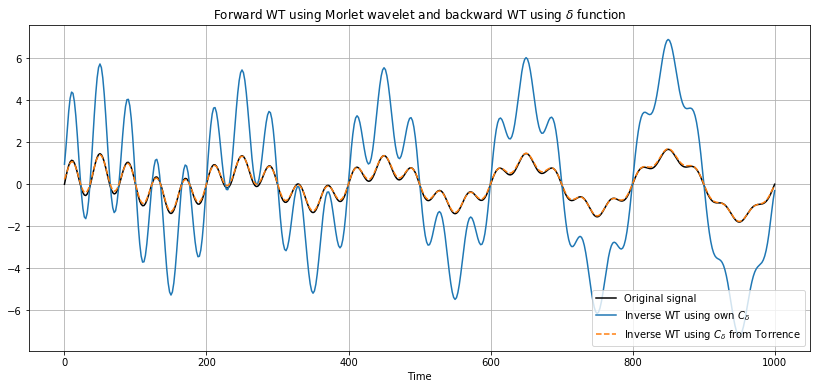

In [40]:
#reconstructing signal 
#tile over sj for easier multiplication
a, b = WT.shape
c = sj.size
if a == c:
    sj_tile = (np.ones([b, 1]) * sj).transpose()
elif b == c:
    sj_tile = np.ones([a, 1]) * sj

#inverse formula using delta function
iWT = (dj * np.sqrt(dt)) / (wavelet.cdelta * wavelet.psi(0)) * (np.real(WT) / sj_tile**0.5).sum(axis=0)
iWT_own = (dj * np.sqrt(dt)) / (own_cdelta * wavelet.psi(0)) * (np.real(WT) / sj_tile**0.5).sum(axis=0)

fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(t,x0,label="Original signal",color="k")
plt.plot(t,iWT_own,label="Inverse WT using own $C_\delta$")
plt.plot(t,iWT,label="Inverse WT using $C_{\delta}$ from Torrence",linestyle="--")
plt.title("Forward WT using Morlet wavelet and backward WT using $\delta$ function")
plt.xlabel("Time")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### finding $C_\psi$ using general formula:
- $C_\psi  = (2\pi)^n \int_{R^n} |\hat{\psi}(k)|^2 \frac{d^nk}{|k|^n} $

In [123]:
from scipy.integrate import simps
#wavelet=DOG()
wavelet=DOG()
N=100
dt=1
# Fourier angular frequencies to get omega
ftfreqs =  np.fft.fftfreq(N, dt)[1:] *2 * np.pi 

C_psi = simps(np.abs(wavelet.psi_ft(ftfreqs))**2/(2*np.abs(ftfreqs))) #runs from 0 to infinity
C_psi

5.9827522879367523

*** Check Chen and Chu paper  - equations for reconstruction are defined differently***

#### How does the reconstruction factor come into play for Morse?

- $W_{\delta}(s) = \frac{1}{N} \sum_{k=0}^{N-1} \hat{\psi}*(s\omega_k)$
    

- use Dirac $\delta$ function for reconstruction
- Using properties of the $\delta$ function, ${C_\delta}$ can be found as:

 ${C_{\delta}= \frac{\delta j \delta t^{1/2}}{\psi_0(0)} \sum_{j=0}^J  \frac{R \{W_\delta(s_j) \}}{s_j^{1/2} }  }$

- However - Recall no analytic equation for time-domain Morse wavelet
- Get frequency domain wavelet ($\hat{\psi}$), compute time domain wavelet ($\psi$) through inverse and then compute ${\psi_0(0)}$?

### Case 4: Reconstruction of signal using Morse wavelet for forward and $\delta$ function for reverse transform